# r/feminism experiment analysis
J. Nathan Matias, Nov 12, 2019
* [Pre-analysis plan on OSF](https://osf.io/b42q6/)

In [21]:
library(MASS)
library(ggplot2)
library(gmodels) #contains CrossTable
library(ri2)
options(repr.plot.width=7, repr.plot.height=3)

## NOTE: THE SOFTWARE CONTINUED TO ASSIGN PARTICIPANTS EVEN AFTER
## THE EXPERIMENT INTERVENTIONS WERE HALTED, AS CONFIRMED FROM REDDIT ARCHIVES
## FOR THIS REASON, WE REMOVE ALL PARTICIPANTS ASSIGNED AFTER THE TREATMENT DATE

accounts <- read.csv("../data/r-feminism-study-data-merged-10.17.2019.csv",
                          stringsAsFactors = FALSE)

final.treat.date <- as.Date(as.POSIXct(1553046131, origin="1970-01-01"))
accounts$after.treat.date <- as.Date(accounts$assignment_datetime) > final.treat.date

newcomers <- subset(accounts, after.treat.date!=TRUE)

newcomers$complied = newcomers$completed_survey=="True"
newcomers$message.sent = newcomers$message_status == "sent"
newcomers$num.comments <- newcomers$comments_2_weeks
newcomers$TREAT <- newcomers$treatment
newcomers$ingroup <- newcomers$identify_feminist=="Yes"
newcomers$inclusion <- newcomers$community_closeness

sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.14.6

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ri2_0.1.2        estimatr_0.14    randomizr_0.16.1 gmodels_2.18.1  
[5] ggplot2_3.1.0    MASS_7.3-51.1   

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.0       pillar_1.3.1     compiler_3.5.1   plyr_1.8.4      
 [5] base64enc_0.1-3  tools_3.5.1      digest_0.6.18    uuid_0.1-2      
 [9] jsonlite_1.6     evaluate_0.13    tibble_2.0.0     gtable_0.2.0    
[13] texreg_1.36.23   pkgconfig_2.0.2  rlang_0.3.0.1    IRdisplay_0.7.0 
[17] IRkernel_0.8.14  repr_0.19.1      withr_2.1.2      dp

# Codebook


#### Study Participation
* **message.sent**: Was the intervention sent to the account? (true) or had it been entirely banned by reddit by the point at which we attempted to send the intervention (false)
* **complied**: Did the account complete the survey?
* **TREAT**: Did the account receive the intervention? (1)
* **assignment_datetime**: When was the account assigned to join the study?
* **block_id**: What randomization block was the account in?

#### Comments
* **comments_2_weeks**:: The number of comments made by the account over 2 weeks
* **comments_4_weeks**:: The number of comments made by the account over 2 weeks
* **comments_8_weeks**:: The number of comments made by the account over 2 weeks

#### Bans
* **ban_actions**: The total number of within-subreddit ban actions received by the account
* **ban_days_two_weeks**: The number of days the account was banned from posting in the subreddit over 2 weeks
* **ban_days_four_weeks**: The number of days the account was banned from posting in the subreddit over 4 weeks
* **ban_days_eight_weeks**: The number of days the account was banned from posting in the subreddit over 8 weeks

#### Post-Survey Responses
* **ingroup**: Did the account report identifying as a feminist when they first commented in the community?
* **inclusion**: The reported closeness to the r/feminism community on a scale of 1 to 7


### Summary Statistics

In [22]:
first.date <- min(as.Date(newcomers$assignment_datetime))
last.date <- max(as.Date(newcomers$assignment_datetime))

newcomers$assignment.week <- as.integer(difftime(as.Date(newcomers$assignment_datetime),  first.date, units="weeks"))

summary(newcomers$after.treat.date)

   Mode   FALSE 
logical     839 

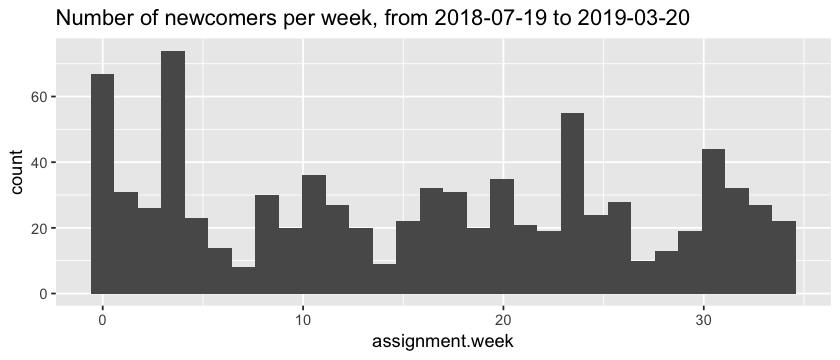

In [23]:
ggplot(newcomers, aes(assignment.week)) +
    geom_histogram(bins=30) +
    ggtitle(paste("Number of newcomers per week, from", first.date, "to", last.date))

In [25]:
nrow(newcomers)
nrow(subset(newcomers, message.sent))
nrow(subset(newcomers, complied))

[1] 839

[1] 839

[1] 220

In [26]:
summary(factor(newcomers$treatment))

0   1 
425 414

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.5256  0.0000 27.0000 

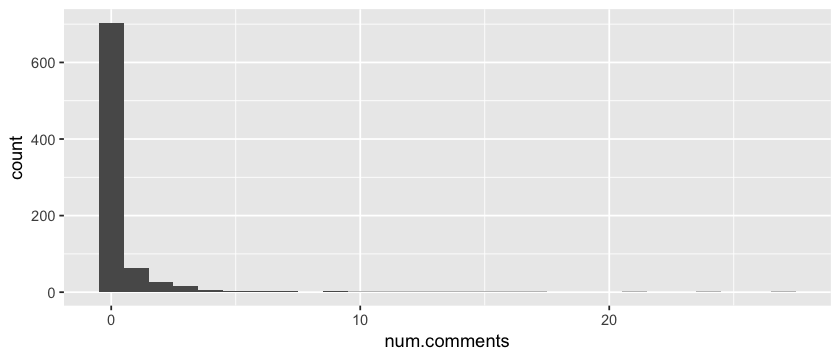

In [27]:
summary(newcomers$num.comments)
ggplot(newcomers, aes(num.comments)) +
    geom_histogram(binwidth=1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1       2       4       4       6       7 

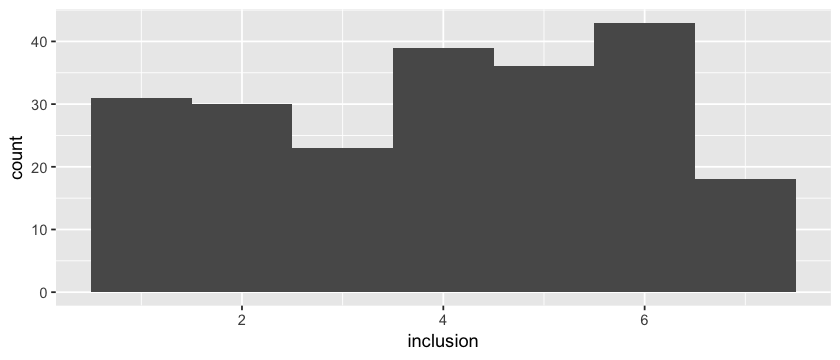

In [28]:
summary(subset(newcomers, complied)$inclusion)
ggplot(subset(newcomers, complied), aes(inclusion)) +
    geom_histogram(binwidth=1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   1.428   0.000  14.000 

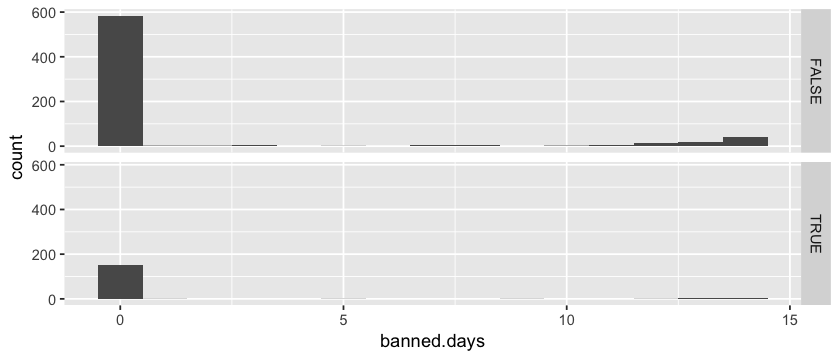

In [44]:
newcomers$banned.days <- newcomers$ban_days_2_weeks
summary(newcomers$banned.days)
ggplot(newcomers, aes(banned.days)) +
    geom_histogram(binwidth=1) +
    facet_grid(ingroup ~ . )

In [54]:
## look at ban rates for ingroup and outgroup
CrossTable(newcomers$banned.days>0, newcomers$ingroup, prop.chisq = FALSE, prop.t = FALSE)


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  839 

 
                          | newcomers$ingroup 
newcomers$banned.days > 0 |     FALSE |      TRUE | Row Total | 
--------------------------|-----------|-----------|-----------|
                    FALSE |       584 |       152 |       736 | 
                          |     0.793 |     0.207 |     0.877 | 
                          |     0.860 |     0.950 |           | 
--------------------------|-----------|-----------|-----------|
                     TRUE |        95 |         8 |       103 | 
                          |     0.922 |     0.078 |     0.123 | 
                          |     0.140 |     0.050 |           | 
--------------------------|-----------|-----------|-----------|
             Column Total |       679 |       160 |       839 | 
                          |     0.809 | 

In [55]:
summary(newcomers$banned.days>0)

   Mode   FALSE    TRUE 
logical     736     103 

In [30]:
summary(factor(subset(newcomers, complied)$identify_feminist))
summary(newcomers$ingroup)

No Undecided       Yes 
       43        17       160

   Mode   FALSE    TRUE 
logical     679     160 

# Questions about Balance in the Sample

In [31]:
## How can we make sense of the message_status field, which should
## indicate that the account never received the intervention?
summary(factor(newcomers$message.sent))
CrossTable(newcomers$message.sent, newcomers$treatment, prop.chisq = FALSE, prop.t = FALSE)
CrossTable(newcomers$message.sent, newcomers$complied, prop.chisq = FALSE, prop.t = FALSE)

TRUE 
 839


 
   Cell Contents
|-------------------------|
|                       N |
|-------------------------|

 
Total Observations in Table:  839 

 
                       | newcomers$treatment 
newcomers$message.sent |         0 |         1 | Row Total | 
-----------------------|-----------|-----------|-----------|
                  TRUE |       425 |       414 |       839 | 
-----------------------|-----------|-----------|-----------|
          Column Total |       425 |       414 |       839 | 
-----------------------|-----------|-----------|-----------|

 

 
   Cell Contents
|-------------------------|
|                       N |
|-------------------------|

 
Total Observations in Table:  839 

 
                       | newcomers$complied 
newcomers$message.sent |     FALSE |      TRUE | Row Total | 
-----------------------|-----------|-----------|-----------|
                  TRUE |       619 |       220 |       839 | 
-----------------------|-----------|-----------|-----------|
 

In [32]:
## What is the balance among survey compliers 
## and among accounts that identified as feminist

summary(newcomers$complied)
CrossTable(newcomers$complied, newcomers$treatment, prop.chisq = FALSE, prop.t = FALSE)
CrossTable(subset(newcomers, complied)$identify_feminist, subset(newcomers, complied)$treatment, prop.chisq = FALSE, prop.t = FALSE)

   Mode   FALSE    TRUE 
logical     619     220 


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  839 

 
                   | newcomers$treatment 
newcomers$complied |         0 |         1 | Row Total | 
-------------------|-----------|-----------|-----------|
             FALSE |       310 |       309 |       619 | 
                   |     0.501 |     0.499 |     0.738 | 
                   |     0.729 |     0.746 |           | 
-------------------|-----------|-----------|-----------|
              TRUE |       115 |       105 |       220 | 
                   |     0.523 |     0.477 |     0.262 | 
                   |     0.271 |     0.254 |           | 
-------------------|-----------|-----------|-----------|
      Column Total |       425 |       414 |       839 | 
                   |     0.507 |     0.493 |           | 
-------------------|-----------|-----------|-----------|

 

 
 

### Create Measure of Comments Per Day

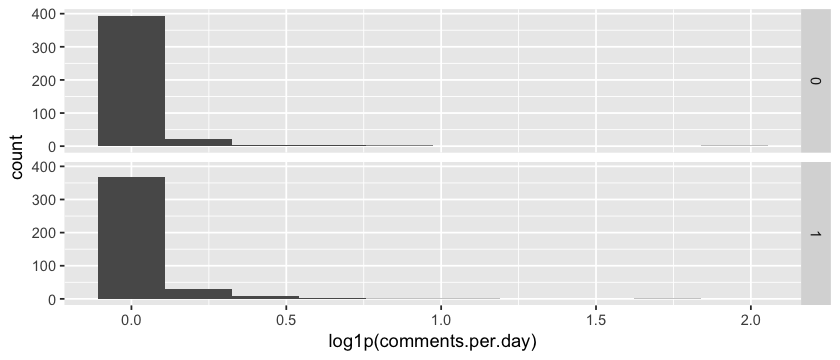

In [33]:
newcomers$eligible.days <- 14 - newcomers$banned.days
newcomers$comments.per.day <- newcomers$num.comments / (newcomers$eligible.days + 1)
ggplot(subset(newcomers, message.sent), aes(log1p(comments.per.day))) +
    geom_histogram(bins=10) +
    facet_grid(treatment ~ . )

# Bivariate Analysis

### Feminist and Closeness to Community

In [69]:
aggregate(FUN="mean", subset(newcomers, complied)[c("ingroup", "inclusion")], 
          by=list(subset(newcomers, complied)$ingroup))

Group.1,ingroup,inclusion
FALSE,0,2.25000
TRUE,1,4.65625


In [75]:
summary(glm.nb(num.comments ~ inclusion + ingroup, data=subset(newcomers, complied)))


Call:
glm.nb(formula = num.comments ~ inclusion + ingroup, data = subset(newcomers, 
    complied), init.theta = 0.141374734, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8855  -0.8074  -0.6834  -0.5116   2.4826  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.7891     0.5175  -3.457 0.000545 ***
inclusion     0.2539     0.1258   2.018 0.043562 *  
ingroupTRUE   0.7637     0.5577   1.370 0.170842    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.1414) family taken to be 1)

    Null deviance: 127.56  on 219  degrees of freedom
Residual deviance: 119.16  on 217  degrees of freedom
AIC: 464.12

Number of Fisher Scoring iterations: 1


              Theta:  0.1414 
          Std. Err.:  0.0266 

 2 x log-likelihood:  -456.1190 

Warning message:
“Removed 619 rows containing non-finite values (stat_bin).”

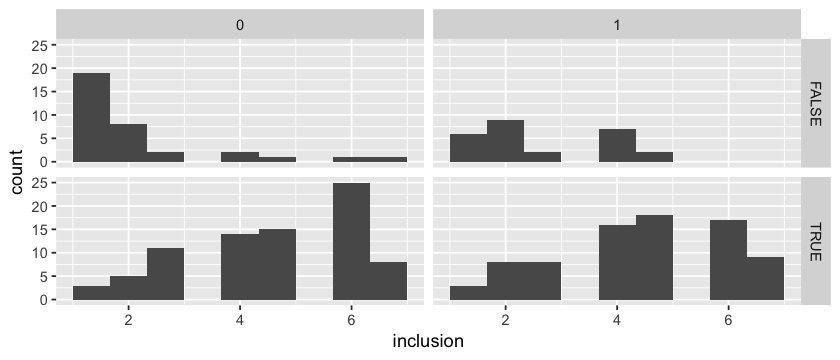

In [35]:
# columns: 0 = control, 1 = treatment
# rows: TRUE = feminist, 1 = unsure or not feminist
ggplot(newcomers, aes(inclusion)) +
    geom_histogram(bins=10) +
    facet_grid(ingroup ~ treatment ) 

# Analyze Results

In [77]:
mean(subset(newcomers, message.sent & treatment==FALSE)$num.comments)

[1] 0.3976471

In [36]:
summary(glm.nb(num.comments ~ treatment + banned.days, data= subset(newcomers, message.sent)))


Call:
glm.nb(formula = num.comments ~ treatment + banned.days, data = subset(newcomers, 
    message.sent), init.theta = 0.09261885155, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6305  -0.6218  -0.5543  -0.5543   2.9609  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.931608   0.183352  -5.081 3.75e-07 ***
treatment    0.507090   0.247255   2.051   0.0403 *  
banned.days  0.004767   0.030749   0.155   0.8768    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.0926) family taken to be 1)

    Null deviance: 335.33  on 838  degrees of freedom
Residual deviance: 331.20  on 836  degrees of freedom
AIC: 1252.4

Number of Fisher Scoring iterations: 1


              Theta:  0.0926 
          Std. Err.:  0.0111 

 2 x log-likelihood:  -1244.4440 

In [41]:
#summary(lm(log1p(num.comments) ~ treatment + banned.days,data=subset(newcomers, message.sent)))

In [42]:
## interpreting the coefficient
#exp(0.507)

In [43]:
summary(glm.nb(num.comments ~ treatment + banned.days, data= subset(newcomers, complied)))


Call:
glm.nb(formula = num.comments ~ treatment + banned.days, data = subset(newcomers, 
    complied), init.theta = 0.1524106293, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8525  -0.8525  -0.7203  -0.2191   2.2876  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept) -0.38014    0.28399  -1.339  0.18070   
treatment    0.78624    0.39010   2.015  0.04385 * 
banned.days -0.23357    0.08066  -2.896  0.00378 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.1524) family taken to be 1)

    Null deviance: 133.99  on 219  degrees of freedom
Residual deviance: 119.34  on 217  degrees of freedom
AIC: 458.51

Number of Fisher Scoring iterations: 1


              Theta:  0.1524 
          Std. Err.:  0.0291 

 2 x log-likelihood:  -450.5110 

# Inclusion of the Group in the Self Scale

In [253]:
summary(lm(inclusion ~ treatment, data= subset(newcomers, complied)))


Call:
lm(formula = inclusion ~ treatment, data = subset(newcomers, 
    complied))

Residuals:
     Min       1Q   Median       3Q      Max 
-3.09524 -1.91304  0.08696  1.90476  3.08696 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.9130     0.1775  22.041   <2e-16 ***
treatment     0.1822     0.2570   0.709    0.479    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.904 on 218 degrees of freedom
Multiple R-squared:  0.0023,	Adjusted R-squared:  -0.002276 
F-statistic: 0.5027 on 1 and 218 DF,  p-value: 0.4791


In [259]:
summary(lm(inclusion ~ treatment + ingroup, data= subset(newcomers, complied)))


Call:
lm(formula = inclusion ~ treatment + ingroup, data = subset(newcomers, 
    complied))

Residuals:
    Min      1Q  Median      3Q     Max 
-3.6901 -1.2210  0.0444  1.3767  4.7790 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.22105    0.22345   9.940   <2e-16 ***
treatment    0.06681    0.21306   0.314    0.754    
ingroupTRUE  2.40221    0.23895  10.053   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.576 on 217 degrees of freedom
Multiple R-squared:  0.3193,	Adjusted R-squared:  0.313 
F-statistic:  50.9 on 2 and 217 DF,  p-value: < 2.2e-16


In [272]:
p.adjust(c(0.0403, 0.479 ), method="hochberg")

[1] 0.0806 0.4790